In [1]:
import neuralflow
import numpy as np
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec
from neuralflow.utilities.visualization_functions import plot_spikes, plot_fitting_results
import warnings


In [2]:
print(neuralflow.__file__)

/Users/xinzheng/Desktop/Engel_rotation/TestBrainFlow/neuralflow/__init__.py


## Optimize model potential using the synthetic data

We test if with periodic boundary condition we can recover the potential function. First we simulate a synthetic dataset with perioidc energy function and firing rate function.

One twick in the maximizing likelihood is that for periodic boundary condition, we need to ensure no flux in steady state solution which is equivalent to having 

$$\int_{-1}^{1} \mathbf F(x) dx = 0 $$

for which we implement by projecting $\mathbf F $ back to the correct likelihood surface in each SGD iteration. Proof see other documents. 

<br />
<br />

Followed is the procedure for inference adapted from Example 4:

1) Specify the EnergyModel variable for fitting. All parameters are the same as the ground-truth, but the initial guess for potential is the constant potential (uniform peq model). To accelerate the evaluation of this cell, we also reduce grid resolution (`{'Np': 8, 'Ne': 16}`).

2) Specify options. Here we want to optimize the model with the correct assumptions: circular boundary mode. To accelerate computation time, we set max_iteration to 50, however, you may want to increase it.

3) Optimize the model with the selected parameters.

4) Visualise the results.

In [3]:
def plot_latent(em):
    '''helper func for plotting latent energy model'''
    
    fig, ax = plt.subplots(nrows = 2, figsize = [5, 8], 
                       gridspec_kw={'height_ratios': [1, 2]})

    # plot initial distribution
    ax[0].plot(em.x_d_, em.p0_, color = "navy", linewidth = 1.5) # pltential function

    # Hide the right and top spines
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax[0].set_yticks(ticks = [0, 6])
    ax[0].set_xticks(ticks = [-1, 0, 1])
    ax[0].set_xlim([-1,1])
    ax[0].set_ylim([0,6])

    ax[0].xaxis.set_ticks_position('bottom')
    ax[0].set_ylabel("$p_{0}(x)$", fontsize = 14)
    ax[0].set_title("Initial Distribution", fontsize = 16)

    # plot potential function ----------------------------------------
    ax[1].plot(em.x_d_, -np.log(em.peq_), color = "black", linewidth = 2) # pltential function


    # Hide the right and top spines
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax[1].set_yticks([])
    ax[1].set_xticks(ticks = [-1, 0, 1])
    ax[1].set_xlim([-1.1,1.05])
    ax[1].xaxis.set_ticks_position('bottom')
    ax[1].set_ylabel("$\Phi (x)$", fontsize = 14)
    ax[1].set_title("Potential Function", fontsize = 16)

    plt.show()
    
    fig.savefig("latent.pdf")

In [4]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# single well p0 (bell curve), with flat potential:
EnergyModelParams={'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 64}}},
               'Nv': 447,
               'peq_model':{"model": "sine_waves", "params": {}},
               'D0': 0.2,
               'p0_model':{"model": "single_well", "params": {"miu": 200, "xmin": .5}},
               'boundary_mode':'circular',
               'num_neuron':1,
               'firing_model':[{"model": "sinus", "params": {"bias": 50, "amp": 40}}],
               'verbose':True}
               

In [5]:
em_sin =neuralflow.EnergyModel(**EnergyModelParams)
# (0, 5) is duration * number of trials:
data_gen_params={'deltaT':0.0001, 'time_epoch':  [(0,5)]*200, 'last_event_is_spike':False}
spikes, time_bins, diff_traj, metadata=em_sin.generate_data(**data_gen_params)

100%|██████████| 200/200 [01:31<00:00,  2.17it/s]


### Plot the latent parameter settings:

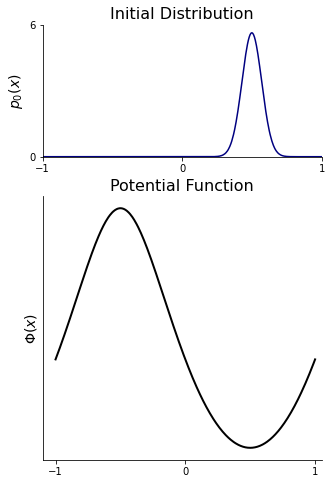

In [6]:
plot_latent(em_sin)

In [7]:
EnergyModelParams={'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 16}}},
               'Nv': 111,
               'peq_model':{"model": "uniform", "params": {}},
               'D0':0.2,
               'p0_model':{"model": "single_well", "params": {"miu": 200, "xmin": 0.5}},
               'boundary_mode':'circular',
               'num_neuron':1,
               'firing_model':[{"model": "sinus", "params": {"bias": 50, "amp": 40}}],
               'verbose':True
               }

In [8]:
em_fit=neuralflow.EnergyModel(**EnergyModelParams)
options={}
options['data']={'dataTR':spikes}
options['save']=None
options['inference']={'metadataTR':{'last_event_is_spike':False,'absorption_event':False}}
options['optimization']={'gamma':{'F':0.002},'max_iteration':50,'loglik_tol':0,'etaf':0}
em_fit.fit('GD',options);

100%|██████████| 50/50 [04:14<00:00,  5.08s/it]


### Visualize optimization:

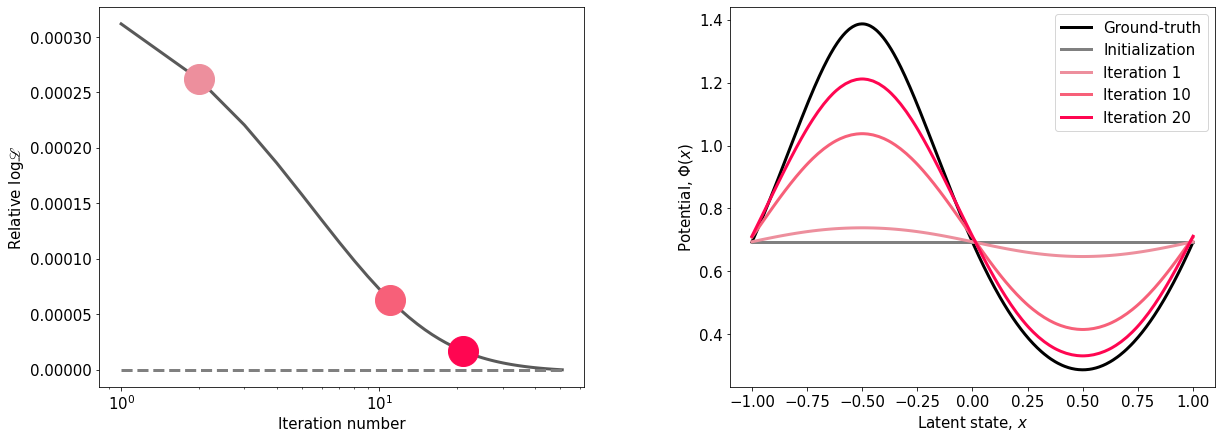

In [9]:
#Visualise the results

fig=plt.figure(figsize=(20,7))
gs=gridspec.GridSpec(1,2,wspace=0.3)
colors=[[0.9294, 0.5608, 0.6157], [0.9686, 0.3765, 0.4745], [1.0000, 0.0235, 0.3176]]
#Plot the loglikelihood on iterations 4,17 and the one where fitted loglik matches the ground-truth one
ll_gt=em_sin.score(options['data']['dataTR'],metadata=options['inference']['metadataTR'])
rel_lls = (ll_gt-em_fit.iterations_GD_['logliks'])/ll_gt
example_iterations=[1,4,8]
plot_fitting_results(gs[0],gs[1],em_fit,em_sin,options,[1,10,20],colors)

fig.savefig("optimization.pdf")